In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pytorchcv import *

## Dataset

In [3]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import opendatasets as od

In [5]:
def download_data(src, data_dir = None):
    if data_dir:
        od.download(src, data_dir = data_dir)
    else:
        od.download(src)

In [6]:
BANANA_DETECTION = 'https://www.kaggle.com/datasets/huiyangfeng/bananadetection'

In [7]:
download_data(BANANA_DETECTION)

100%|██████████| 133M/133M [00:08<00:00, 17.1MB/s]


In [8]:
BANANA_DIR = '/content/bananadetection/banana-detection'

In [9]:
import pandas as pd
import os
from PIL import Image
def read_data_bananas(root, is_train = True):
    """Read the banana detection dataset images and labels."""
    data_dir = root
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for i, (img_name, target) in enumerate(csv_data.iterrows()):
        images.append(Image.open(os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', f'{img_name}')))
        # Here `target` contains (class, upper-left x, upper-left y,
        # lower-right x, lower-right y), where all the images have the same
        # banana class (index 0)
        targets.append(list(target))
        if i == 99:
            break
    return images, torch.tensor(targets).unsqueeze(1)/256

In [10]:
class BananasDataset(torch.utils.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    def __init__(self, root, is_train, transform = None):
        self.transform = transform
        self.features, self.labels = read_data_bananas(root, is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if is_train else f' validation examples'))

    def __getitem__(self, idx):
        if self.transform:
            return (self.transform(self.features[idx]).float(), self.labels[idx])
        else:
            return (transforms.functional.to_tensor(self.features[idx]).float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [11]:
def load_data_bananas(root, batch_size, transform = None, pin_memory = True):
    train_loader = torch.utils.data.DataLoader(BananasDataset(root = root, is_train = True, transform = transform), batch_size = batch_size, shuffle = True, pin_memory = pin_memory)
    val_loader = torch.utils.data.DataLoader(BananasDataset(root = root, is_train = False, transform = transform), batch_size = batch_size, pin_memory = pin_memory)
    return train_loader, val_loader

In [12]:
train_data = BananasDataset(root = BANANA_DIR, is_train = True)

read 100 training examples


In [13]:
train_set, val_set = torch.utils.data.random_split(train_data, [70, 30])

In [14]:
batch_size = 1
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle = True, 
                                         drop_last = True,
                                         pin_memory = True)
test_iter = torch.utils.data.DataLoader(val_set, batch_size, shuffle = False,
                                        drop_last = True,
                                        pin_memory = True)

In [15]:
#batch_size, edge_size = 1, 256
#train_iter, val_iter = load_data_bananas(root = BANANA_DIR, batch_size = batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 1, 5]))

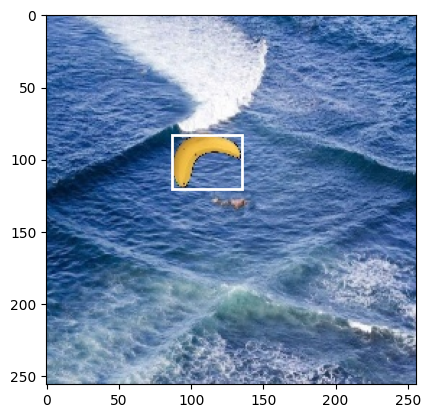

In [16]:
fig, ax = plt.subplots()
# fig.set_size_inches = [10,3]
ax.imshow(batch[0][0].permute(1,2,0))
show_bboxes(ax, batch[1][0][:,1:5]*256, colors = ['w'])

## Model

In [17]:
class RoI_Pool(nn.Module):
    def __init__(self, output_size, spatial_scale):
        super(RoI_Pool, self).__init__()
        self.output_size = output_size
        self.spatial_scale = spatial_scale

    def forward(self, X, rois):
        return torchvision.ops.roi_pool(X, rois, output_size = self.output_size, spatial_scale = self.spatial_scale)

In [18]:
a = torch.arange(3072.).reshape(1,3,32,32)
a

tensor([[[[0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 2.9000e+01,
           3.0000e+01, 3.1000e+01],
          [3.2000e+01, 3.3000e+01, 3.4000e+01,  ..., 6.1000e+01,
           6.2000e+01, 6.3000e+01],
          [6.4000e+01, 6.5000e+01, 6.6000e+01,  ..., 9.3000e+01,
           9.4000e+01, 9.5000e+01],
          ...,
          [9.2800e+02, 9.2900e+02, 9.3000e+02,  ..., 9.5700e+02,
           9.5800e+02, 9.5900e+02],
          [9.6000e+02, 9.6100e+02, 9.6200e+02,  ..., 9.8900e+02,
           9.9000e+02, 9.9100e+02],
          [9.9200e+02, 9.9300e+02, 9.9400e+02,  ..., 1.0210e+03,
           1.0220e+03, 1.0230e+03]],

         [[1.0240e+03, 1.0250e+03, 1.0260e+03,  ..., 1.0530e+03,
           1.0540e+03, 1.0550e+03],
          [1.0560e+03, 1.0570e+03, 1.0580e+03,  ..., 1.0850e+03,
           1.0860e+03, 1.0870e+03],
          [1.0880e+03, 1.0890e+03, 1.0900e+03,  ..., 1.1170e+03,
           1.1180e+03, 1.1190e+03],
          ...,
          [1.9520e+03, 1.9530e+03, 1.9540e+03,  ..., 1.9810

In [19]:
rois = torch.Tensor([[2, 0, 0, 0, 0], [2, 0, 10/32, 30/32, 30/32]])

In [20]:
roi_pool = RoI_Pool(output_size = (2, 2), spatial_scale = 1)
roied_a = roi_pool(a, rois*torch.tensor([0, 32,32,32,32]))
print(roied_a.shape)
roied_a

torch.Size([2, 3, 2, 2])


tensor([[[[   0.,    0.],
          [   0.,    0.]],

         [[1024., 1024.],
          [1024., 1024.]],

         [[2048., 2048.],
          [2048., 2048.]]],


        [[[ 655.,  670.],
          [ 975.,  990.]],

         [[1679., 1694.],
          [1999., 2014.]],

         [[2703., 2718.],
          [3023., 3038.]]]])

In [21]:
RoIPool = torchvision.ops.RoIPool(output_size = (2,2), spatial_scale = 1)
roied_a_ = RoIPool(a, rois*torch.tensor([0, 32,32,32,32]))
print(roied_a_.shape)
roied_a_

torch.Size([2, 3, 2, 2])


tensor([[[[   0.,    0.],
          [   0.,    0.]],

         [[1024., 1024.],
          [1024., 1024.]],

         [[2048., 2048.],
          [2048., 2048.]]],


        [[[ 655.,  670.],
          [ 975.,  990.]],

         [[1679., 1694.],
          [1999., 2014.]],

         [[2703., 2718.],
          [3023., 3038.]]]])

In [22]:
class RPN(nn.Module):
    def __init__(self, conv_channels, sizes, ratios):
        super(RPN, self).__init__()
        self.sizes = sizes
        self.ratios = ratios
        num_anchors = len(sizes) + len(ratios) - 1
        self.conv = nn.LazyConv2d(conv_channels, 3, padding = 1)
        self.binary_conv = nn.LazyConv2d(2*num_anchors, kernel_size = 1)
        self.bbox_conv = nn.LazyConv2d(4*num_anchors, kernel_size = 1)

    def forward(self, X):
        X = self.conv(X)
        binary_preds = self.binary_conv(X).reshape(X.shape[0], -1, 2)
        bbox_preds = self.bbox_conv(X).reshape(X.shape[0], -1, 4)
        anchors = multibox_prior(X, self.sizes, self.ratios)
        return anchors, binary_preds, bbox_preds

In [23]:
pretrained_net = torchvision.models.vgg19(pretrained = True)
print(pretrained_net)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 71.0MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [24]:
net = nn.Sequential(*list(pretrained_net.children())[0][:27])
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [25]:
X = torch.Tensor(1, 3, 256, 256)

In [26]:
sizes = [0.2, 0.37, 0.54, 0.71, 0.88]
ratios = [1, 2, 0.5]
num_anchors = len(sizes) + len(ratios) - 1

In [27]:
rpn = RPN(conv_channels = 512, sizes = sizes, ratios = ratios)
anchors, binary_preds, bbox_preds = rpn(net(X))
print(anchors.shape)
print(binary_preds.shape)
print(bbox_preds.shape)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([1, 7168, 4])
torch.Size([1, 7168, 2])
torch.Size([1, 7168, 4])


In [ ]:
def nms(boxes, scores, iou_threshold, pos_threshold = 0.7):
    """Sort confidence scores of predicted bounding boxes."""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # Indices of predicted bounding boxes that will be kept
    while B.numel() > 0:
        i = B[0]
        if scores[i] > pos_threshold:
            keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [ ]:
keep = nms(bbox_preds[0], binary_preds[0,:,1].reshape(-1), iou_threshold = 0.5)
keep.shape

torch.Size([232])

In [ ]:
len(keep)

6074

In [ ]:
### Batch_size = 1
def NMS(boxes, scores, iou_threshold, pos_threshold = 0.7):
    scores = F.softmax(scores, dim = 2)
    keep = nms(boxes[0], scores[0,:,1].reshape(-1), iou_threshold, pos_threshold)
    keeps = boxes[0, keep]
    res = torch.zeros(keeps.shape[0], 5)
    res[:,1:] = keeps
    return res.to(boxes.device).detach()

In [47]:
def non_maximum_suppression(cls_probs, offset_preds, anchors, nms_threshold=0.7, pos_threshold=0.009999999):
    output = multibox_detection(cls_probs, offset_preds, anchors, nms_threshold, pos_threshold)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx].detach()[:,1:]

In [29]:
keep = NMS(bbox_preds, binary_preds, iou_threshold = 0.5, pos_threshold = 0.7)
keep.shape

NameError: ignored

In [30]:
roi_pool(net(X), keep).shape

NameError: ignored

In [63]:
class FasterRCNN(nn.Module):
    def __init__(self, sizes, ratios, rpn_channels = 512, roi_channels = 7, num_classes = 1):
        super(FasterRCNN, self).__init__()
        self.sizes = sizes
        self.ratios = ratios
        self.num_classes = num_classes
        self.roi_pool = RoI_Pool(roi_channels, spatial_scale = 1)
        pretrained_net = torchvision.models.vgg19(pretrained = True)
        self.pretrained_net = nn.Sequential(*list(pretrained_net.children())[0][:27])
        self.RPN = RPN(rpn_channels, sizes, ratios)
        self.flatten = nn.Flatten()
        self.cls_layer = nn.LazyLinear(num_classes + 1)
        self.bbox_layer = nn.LazyLinear(4)
        # self.bbox_layer = nn.Sequential(
        #     nn.LazyLinear(512),
        #     nn.ReLU(),
        #     nn.LazyLinear(4),
        # )
    
    def forward(self, X):
        X = self.pretrained_net(X)
        H, W = X.shape[-2:]
        mask = torch.Tensor([0, W, H, W, H]).to(X.device)
        anchors, binary_preds, binary_bbox_preds = self.RPN(X)
        # rois = NMS(binary_bbox_preds, binary_preds, iou_threshold = 0.5, pos_threshold = 0.5) # batch_size = 1
        binary_probs = F.softmax(binary_preds, dim = 2).permute(0, 2, 1)
        rois = non_maximum_suppression(binary_probs, binary_bbox_preds, anchors, nms_threshold = 0.5)
        X = self.roi_pool(X, rois*mask)
        X = self.flatten(X)
        cls_preds = self.cls_layer(X).unsqueeze(0)
        bbox_preds = self.bbox_layer(X).unsqueeze(0)
        return anchors, binary_preds, binary_bbox_preds, rois[:,1:].unsqueeze(0), cls_preds, bbox_preds

In [86]:
net = FasterRCNN(sizes, ratios)

In [50]:
X = torch.arange(3.*256*256).reshape(1, 3, 256, 256)
anchors, binary_preds, binary_bbox_preds, rois, cls_preds, bbox_preds = net(X)
print(anchors.shape)
print(binary_preds.shape)
print(binary_bbox_preds.shape)
print(rois.shape)
print(cls_preds.shape)
print(bbox_preds.shape)

torch.Size([64, 5])
torch.Size([1, 7168, 4])
torch.Size([1, 7168, 2])
torch.Size([1, 7168, 4])
torch.Size([1, 64, 4])
torch.Size([1, 64, 2])
torch.Size([1, 64, 4])


In [51]:
print(anchors[:,:5,:])

tensor([[[-0.0844, -0.0844,  0.1156,  0.1156],
         [-0.1694, -0.1694,  0.2006,  0.2006],
         [-0.2544, -0.2544,  0.2856,  0.2856],
         [-0.3394, -0.3394,  0.3706,  0.3706],
         [-0.4244, -0.4244,  0.4556,  0.4556]]])


In [52]:
print(binary_preds[:,:5,:])

tensor([[[ 6971.8730,  8259.1826],
         [14381.4541, 10836.6270],
         [ 7401.1499,  5923.1626],
         [ 5579.3330,  5498.7217],
         [ 5497.6479,  5497.7500]]], grad_fn=<SliceBackward0>)


In [53]:
print(binary_bbox_preds[:,:5,:])

tensor([[[   45.1252, -6664.4863,   359.0360,  2467.2847],
         [ 4654.5273,  5653.0557,  6478.4229,  6685.2881],
         [ 6685.5664,  6685.4834,  6685.4072,  6685.3350],
         [ 6685.2607,  6685.1899,  6685.1162,  6685.0508],
         [ 6684.9751,  6684.9126,  6684.8369,  6684.7646]]],
       grad_fn=<SliceBackward0>)


In [54]:
print(rois[:,:5,:])

tensor([[[-2.6112e+02, -2.6094e+02, -2.6112e+02, -2.6094e+02],
         [-6.6999e+27,        -inf,  6.6999e+27,         inf],
         [-3.7367e+01, -7.8850e+01,  3.9339e+01,  8.1400e+01],
         [       -inf, -1.8542e+02,         inf,  2.3628e+02],
         [-7.3199e+00, -7.1387e+00,  9.1895e+00,  9.4507e+00]]])


In [55]:
print(cls_preds[:,:5])

tensor([[[-3.0124e-03, -5.9165e-03],
         [-3.0124e-03, -5.9165e-03],
         [-1.5838e+04,  3.8500e+03],
         [-3.0124e-03, -5.9165e-03],
         [-1.5838e+04,  3.8500e+03]]], grad_fn=<SliceBackward0>)


In [56]:
print(bbox_preds[:,:5,:])

tensor([[[ 6.3011e-04,  2.7160e-03,  5.9507e-03,  5.5473e-03],
         [ 6.3011e-04,  2.7160e-03,  5.9507e-03,  5.5473e-03],
         [-1.0086e+03,  3.6513e+03, -1.1324e+04,  1.1212e+04],
         [ 6.3011e-04,  2.7160e-03,  5.9507e-03,  5.5473e-03],
         [-1.0086e+03,  3.6513e+03, -1.1324e+04,  1.1212e+04]]],
       grad_fn=<SliceBackward0>)


## Defining Loss and Evaluation Functions

In [57]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                  cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                  bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [58]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
                  cls_labels.dtype) == cls_labels).sum())
def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

## Training the Model

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [151]:
trainer = torch.optim.SGD(net.parameters(), lr=0.00001, momentum = 0.9, weight_decay=5e-4)

class err 1.87e-01, bbox mae 7.03e-03
77.4 examples/sec on cuda


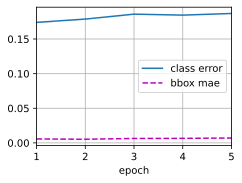

In [94]:
num_epochs, timer = 5, Timer()
animator = Animator(xlabel = 'epoch', xlim = [1, num_epochs],
                    legend = ['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    metric = Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        binary_Y = Y.clone()
        binary_Y[:,:,0] = 0
        anchors, binary_preds, binary_bbox_preds, rois, cls_preds, bbox_preds = net(X)

        binary_bbox_labels, binary_bbox_masks, binary_labels = multibox_target(anchors, binary_Y)
        binary_loss = calc_loss(binary_preds, binary_labels, binary_bbox_preds.reshape(binary_bbox_preds.shape[0], -1), binary_bbox_labels, binary_bbox_masks)

        bbox_labels, bbox_masks, cls_labels = multibox_target(rois, Y)
        loss = calc_loss(cls_preds, cls_labels, bbox_preds.reshape(bbox_preds.shape[0], -1), bbox_labels, bbox_masks)

        total_loss = binary_loss*0.5 + loss*0.5
        # total_loss.mean().backward()
        binary_loss.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds.reshape(bbox_preds.shape[0], -1), bbox_labels, bbox_masks),
                   bbox_labels.numel())
        print(binary_loss, loss, total_loss)
    cls_err, bbox_mae = 1 - metric[0]/metric[1], metric[2]/metric[3]
    print(f'Epoch: {epoch}, cls_err: {cls_err}, bbox_mae: {bbox_mae}')
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
f'{str(device)}')

class err 3.92e-03, bbox mae 4.51e-03
77.4 examples/sec on cuda


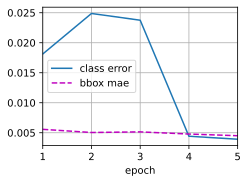

In [103]:
num_epochs, timer = 5, Timer()
animator = Animator(xlabel = 'epoch', xlim = [1, num_epochs],
                    legend = ['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    metric = Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        binary_Y = Y.clone()
        binary_Y[:,:,0] = 0
        anchors, binary_preds, binary_bbox_preds, rois, cls_preds, bbox_preds = net(X)

        binary_bbox_labels, binary_bbox_masks, binary_labels = multibox_target(anchors, binary_Y)
        binary_loss = calc_loss(binary_preds, binary_labels, binary_bbox_preds.reshape(binary_bbox_preds.shape[0], -1), binary_bbox_labels, binary_bbox_masks)

        bbox_labels, bbox_masks, cls_labels = multibox_target(rois, Y)
        loss = calc_loss(cls_preds, cls_labels, bbox_preds.reshape(bbox_preds.shape[0], -1), bbox_labels, bbox_masks)

        total_loss = binary_loss*10 + loss
        total_loss.mean().backward()
        # loss.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds.reshape(bbox_preds.shape[0], -1), bbox_labels, bbox_masks),
                   bbox_labels.numel())
        print(binary_loss, loss, total_loss)
    cls_err, bbox_mae = 1 - metric[0]/metric[1], metric[2]/metric[3]
    print(f'Epoch: {epoch}, cls_err: {cls_err}, bbox_mae: {bbox_mae}')
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
f'{str(device)}')

class err 3.79e-03, bbox mae 4.80e-03
78.1 examples/sec on cuda


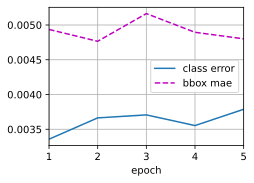

In [152]:
num_epochs, timer = 5, Timer()
animator = Animator(xlabel = 'epoch', xlim = [1, num_epochs],
                    legend = ['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    metric = Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        binary_Y = Y.clone()
        binary_Y[:,:,0] = 0
        anchors, binary_preds, binary_bbox_preds, rois, cls_preds, bbox_preds = net(X)

        binary_bbox_labels, binary_bbox_masks, binary_labels = multibox_target(anchors, binary_Y)
        binary_loss = calc_loss(binary_preds, binary_labels, binary_bbox_preds.reshape(binary_bbox_preds.shape[0], -1), binary_bbox_labels, binary_bbox_masks)

        bbox_labels, bbox_masks, cls_labels = multibox_target(rois, Y)
        loss = calc_loss(cls_preds, cls_labels, bbox_preds.reshape(bbox_preds.shape[0], -1), bbox_labels, bbox_masks)

        total_loss = binary_loss*10 + loss
        total_loss.mean().backward()
        # loss.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds.reshape(bbox_preds.shape[0], -1), bbox_labels, bbox_masks),
                   bbox_labels.numel())
        print(binary_loss, loss, total_loss)
    cls_err, bbox_mae = 1 - metric[0]/metric[1], metric[2]/metric[3]
    print(f'Epoch: {epoch}, cls_err: {cls_err}, bbox_mae: {bbox_mae}')
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
f'{str(device)}')

In [164]:
img, label = train_data[92]
img = img.unsqueeze(0)
label = label.unsqueeze(0)

In [165]:
def predict(X):
    net.eval()
    anchors, binary_preds, binary_bbox_preds, rois, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = multibox_detection(cls_probs, bbox_preds.reshape(bbox_preds.shape[0], -1), rois)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

In [166]:
output= predict(img)
output.shape

torch.Size([23, 6])

In [167]:
output[:5]

tensor([[ 0.0000,  0.9114,  0.7049,  0.4412,  0.9238,  0.6837],
        [ 0.0000,  0.6188,  0.6989,  0.5095,  0.8861,  0.6541],
        [ 0.0000,  0.4990, -0.2075, -0.5338,  0.6054, -0.0708],
        [ 0.0000,  0.4990,  0.2233, -0.3982,  0.7602, -0.1095],
        [ 0.0000,  0.4990,  0.3969, -0.1533,  0.5652, -0.0430]],
       device='cuda:0', grad_fn=<SliceBackward0>)

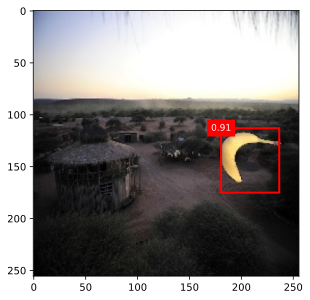

In [169]:
def display(img, output, threshold):
    fig = plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * 256]
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'r')

display(img.squeeze(0).permute(1,2,0), output.cpu(), threshold=0.9)

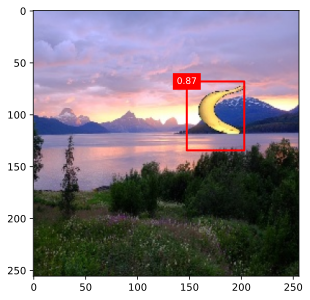

In [170]:
img, label = train_data[21]
img = img.unsqueeze(0)
label = label.unsqueeze(0)

output= predict(img)
output.shape

display(img.squeeze(0).permute(1,2,0), output.cpu(), threshold=0.6)

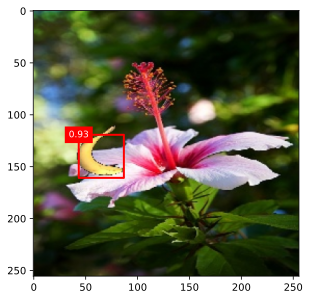

In [171]:
img, label = train_data[15]
img = img.unsqueeze(0)
label = label.unsqueeze(0)

output= predict(img)
output.shape

display(img.squeeze(0).permute(1,2,0), output.cpu(), threshold=0.6)

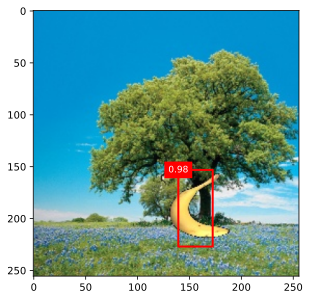

In [172]:
img, label = train_data[8]
img = img.unsqueeze(0)
label = label.unsqueeze(0)

output= predict(img)
output.shape

display(img.squeeze(0).permute(1,2,0), output.cpu(), threshold=0.6)